In [276]:
from collections import defaultdict
import re
import os
import sys
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from Bio import SeqIO, Entrez
import py3Dmol

from dotenv import load_dotenv
env_file = '/home/yuan/bio/bio_omics/src/pipelines/.env'
load_dotenv(dotenv_path = env_file)

%load_ext autoreload
%autoreload 2

src_dir = os.path.dirname(os.getcwd())
print('src direcotry is ', src_dir)
bioomics_dir = '/home/yuan/bio/bio_omics/src'
for _dir in (src_dir, bioomics_dir):
    if _dir not in sys.path:
        sys.path.append(_dir)
print(sys.path)

from bioomics import QueryComplex
from plot_region import PlotRegion

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
src direcotry is  /home/yuan/bio/predict_antibody
['/home/yuan/bio/localcolabfold/localcolabfold/colabfold-conda/lib/python310.zip', '/home/yuan/bio/localcolabfold/localcolabfold/colabfold-conda/lib/python3.10', '/home/yuan/bio/localcolabfold/localcolabfold/colabfold-conda/lib/python3.10/lib-dynload', '', '/home/yuan/bio/localcolabfold/localcolabfold/colabfold-conda/lib/python3.10/site-packages', '/home/yuan/bio/predict_antibody', '/home/yuan/bio/bio_omics/src']


In [125]:
# retrieve sequences
query = "select * from view_ab_dssp;"
seq_df = QueryComplex(True).list_data(query, True)
seq_df['specie'] = seq_df['specie'].map(lambda x: x.replace('_', ' '))
seq_df.head()

,pdb_id,chain_id,allele_name,specie,gene_name,gene_family,chain_type,avg_bfactor,chain_seq,bfactor,dssp_seq
0,3IJH,3IJH_0_A_0,IGKV8-21*01,Mus musculus,IGKV8-21,IGKV8,K,27.2235,IVMTQSPSSLAVSAGEKVTMSCKSSQSLLNSRTRKNYLAWYQQKPG...,"26.46,30.39,25.84,28.99,24.63,23.6,25.03,21.1,...",--EEEE-SEEEEETT--EEEEEEESS--EETTTTEE-EEEEEE-TT...
1,3IJH,3IJH_0_B_0,IGHV7-3*02,Mus musculus,IGHV7-3,IGHV7,H,29.0730,EVMLVESGGGLVQPGNSLRLSCATSGFTFTDYYMSWVRQPPGKALE...,"52.02,32.13,31.54,28.56,27.2,25.46,28.74,24.8,...",--EEEEE--EEE-TT--EEEEEEEESS-GGGS-EEEEEE-TTS--E...
2,3IJH,3IJH_0_C_0,IGKV8-21*01,Mus musculus,IGKV8-21,IGKV8,K,34.2494,IVMTQSPSSLAVSAGEKVTMSCKSSQSLLNSRTRKNYLAWYQQKPG...,"32.95,32.15,27.12,34.57,27.41,31.41,31.04,35.4...",--EEEE-SEEEEETTS-EEEEEEESS--EETTTTEE-EEEEEE-TT...
3,3IJH,3IJH_0_D_0,IGHV7-3*02,Mus musculus,IGHV7-3,IGHV7,H,30.9271,EVMLVESGGGLVQPGNSLRLSCATSGFTFTDYYMSWVRQPPGKALE...,"38.74,25.6,30.22,25.45,29.83,24.47,34.91,32.49...",--EEEEE--EEE-TT--EEEEEEEESS-GGGS-EEEEEE-TTS--E...
4,9IJS,9IJS_0_H_0,IGKV1-21*01,Macaca mulatta,IGKV1-21,IGKV1,K,119.2310,VQLVESGGGLVQPGGSLRLSCAASGFNVYSSSIHWVRQAPGKGLEW...,"120.02,122.64,117.55,123.29,127.82,137.05,144....",--EEE----B--TT---EEEEEESS--GGGEEEEEEEE-TTS-EEE...


In [126]:
# IMGT regions
query = f"""select * from align_vregion
    where pdb_id in (
        select pdb_id from view_antibody
    )
;"""
vregion = QueryComplex(True).list_data(query, True)
vregion['seq_len'] = vregion['end'] - vregion['start'] + 1
vregion.head()

,pdb_id,chain_id,region_name,identity,start,end,seq,seq_len
0,3IJH,3IJH_0_A_0,FR1-IMGT,96.0,1.0,25.0,IVMTQSPSSLAVSAGEKVTMSCKSS,25.0
1,3IJH,3IJH_0_A_0,CDR1-IMGT,100.0,26.0,37.0,QSLLNSRTRKNY,12.0
2,3IJH,3IJH_0_A_0,FR2-IMGT,100.0,38.0,54.0,LAWYQQKPGQSPKLLIY,17.0
3,3IJH,3IJH_0_A_0,CDR2-IMGT,100.0,55.0,57.0,WAS,3.0
4,3IJH,3IJH_0_A_0,FR3-IMGT,100.0,58.0,93.0,TRESGVPDRFTGSGSGTDFTLTISSVQAEDLAVYYC,36.0


In [127]:
vregion['region_name'].value_counts()

region_name
Total        33343
FR2-IMGT     32769
FR3-IMGT     32441
CDR1-IMGT    32315
CDR2-IMGT    32292
FR1-IMGT     31969
CDR3-IMGT    29736
Name: count, dtype: int64

In [128]:
df = pd.merge(vregion, seq_df, how='left', on='chain_id')
df.head()

,pdb_id_x,chain_id,region_name,identity,start,end,seq,seq_len,pdb_id_y,allele_name,specie,gene_name,gene_family,chain_type,avg_bfactor,chain_seq,bfactor,dssp_seq
0,3IJH,3IJH_0_A_0,FR1-IMGT,96.0,1.0,25.0,IVMTQSPSSLAVSAGEKVTMSCKSS,25.0,3IJH,IGKV8-21*01,Mus musculus,IGKV8-21,IGKV8,K,27.2235,IVMTQSPSSLAVSAGEKVTMSCKSSQSLLNSRTRKNYLAWYQQKPG...,"26.46,30.39,25.84,28.99,24.63,23.6,25.03,21.1,...",--EEEE-SEEEEETT--EEEEEEESS--EETTTTEE-EEEEEE-TT...
1,3IJH,3IJH_0_A_0,CDR1-IMGT,100.0,26.0,37.0,QSLLNSRTRKNY,12.0,3IJH,IGKV8-21*01,Mus musculus,IGKV8-21,IGKV8,K,27.2235,IVMTQSPSSLAVSAGEKVTMSCKSSQSLLNSRTRKNYLAWYQQKPG...,"26.46,30.39,25.84,28.99,24.63,23.6,25.03,21.1,...",--EEEE-SEEEEETT--EEEEEEESS--EETTTTEE-EEEEEE-TT...
2,3IJH,3IJH_0_A_0,FR2-IMGT,100.0,38.0,54.0,LAWYQQKPGQSPKLLIY,17.0,3IJH,IGKV8-21*01,Mus musculus,IGKV8-21,IGKV8,K,27.2235,IVMTQSPSSLAVSAGEKVTMSCKSSQSLLNSRTRKNYLAWYQQKPG...,"26.46,30.39,25.84,28.99,24.63,23.6,25.03,21.1,...",--EEEE-SEEEEETT--EEEEEEESS--EETTTTEE-EEEEEE-TT...
3,3IJH,3IJH_0_A_0,CDR2-IMGT,100.0,55.0,57.0,WAS,3.0,3IJH,IGKV8-21*01,Mus musculus,IGKV8-21,IGKV8,K,27.2235,IVMTQSPSSLAVSAGEKVTMSCKSSQSLLNSRTRKNYLAWYQQKPG...,"26.46,30.39,25.84,28.99,24.63,23.6,25.03,21.1,...",--EEEE-SEEEEETT--EEEEEEESS--EETTTTEE-EEEEEE-TT...
4,3IJH,3IJH_0_A_0,FR3-IMGT,100.0,58.0,93.0,TRESGVPDRFTGSGSGTDFTLTISSVQAEDLAVYYC,36.0,3IJH,IGKV8-21*01,Mus musculus,IGKV8-21,IGKV8,K,27.2235,IVMTQSPSSLAVSAGEKVTMSCKSSQSLLNSRTRKNYLAWYQQKPG...,"26.46,30.39,25.84,28.99,24.63,23.6,25.03,21.1,...",--EEEE-SEEEEETT--EEEEEEESS--EETTTTEE-EEEEEE-TT...


In [129]:
def region_bfactor(row):
    try:
        start, end = int(row['start'])-1, int(row['end'])
        if end > start:
            bfactors = row['bfactor'].split(',')
            return ','.join(bfactors[start:end])
    except Exception as e:
        pass
    return np.nan
df['region_bfactor'] = df.apply(region_bfactor, axis=1)

In [146]:
def region_avg_bfactor(row):
    try:
        start, end = int(row['start'])-1, int(row['end'])
        if end > start:
            bfactors = row['bfactor'].split(',')[start:end]
            return np.mean([float(i) for i in bfactors])
    except Exception as e:
        pass
    return np.nan
df['region_avg_bfactor'] = df.apply(region_avg_bfactor, axis=1)

In [131]:
def region_dssp(row):
    try:
        start, end = int(row['start'])-1, int(row['end'])
        if end > start:
            return row['dssp_seq'][start:end]
    except Exception as e:
        pass
    return np.nan
df['region_dssp'] = df.apply(region_dssp, axis=1)

In [287]:
df.head()

,pdb_id_x,chain_id,region_name,identity,start,end,seq,seq_len,pdb_id_y,allele_name,...,gene_name,gene_family,chain_type,avg_bfactor,chain_seq,bfactor,dssp_seq,region_bfactor,region_avg_bfactor,region_dssp
0,3IJH,3IJH_0_A_0,FR1-IMGT,96.0,1.0,25.0,IVMTQSPSSLAVSAGEKVTMSCKSS,25.0,3IJH,IGKV8-21*01,...,IGKV8-21,IGKV8,K,27.2235,IVMTQSPSSLAVSAGEKVTMSCKSSQSLLNSRTRKNYLAWYQQKPG...,"26.46,30.39,25.84,28.99,24.63,23.6,25.03,21.1,...",--EEEE-SEEEEETT--EEEEEEESS--EETTTTEE-EEEEEE-TT...,"26.46,30.39,25.84,28.99,24.63,23.6,25.03,21.1,...",26.102400,--EEEE-SEEEEETT--EEEEEEES
1,3IJH,3IJH_0_A_0,CDR1-IMGT,100.0,26.0,37.0,QSLLNSRTRKNY,12.0,3IJH,IGKV8-21*01,...,IGKV8-21,IGKV8,K,27.2235,IVMTQSPSSLAVSAGEKVTMSCKSSQSLLNSRTRKNYLAWYQQKPG...,"26.46,30.39,25.84,28.99,24.63,23.6,25.03,21.1,...",--EEEE-SEEEEETT--EEEEEEESS--EETTTTEE-EEEEEE-TT...,"31.77,27.14,23.7,29.21,33.73,38.68,36.63,31.21...",29.497500,S--EETTTTEE-
2,3IJH,3IJH_0_A_0,FR2-IMGT,100.0,38.0,54.0,LAWYQQKPGQSPKLLIY,17.0,3IJH,IGKV8-21*01,...,IGKV8-21,IGKV8,K,27.2235,IVMTQSPSSLAVSAGEKVTMSCKSSQSLLNSRTRKNYLAWYQQKPG...,"26.46,30.39,25.84,28.99,24.63,23.6,25.03,21.1,...",--EEEE-SEEEEETT--EEEEEEESS--EETTTTEE-EEEEEE-TT...,"20.05,19.22,18.84,16.01,19.19,17.58,19.95,25.1...",20.887647,EEEEEE-TTS--EEEEE
3,3IJH,3IJH_0_A_0,CDR2-IMGT,100.0,55.0,57.0,WAS,3.0,3IJH,IGKV8-21*01,...,IGKV8-21,IGKV8,K,27.2235,IVMTQSPSSLAVSAGEKVTMSCKSSQSLLNSRTRKNYLAWYQQKPG...,"26.46,30.39,25.84,28.99,24.63,23.6,25.03,21.1,...",--EEEE-SEEEEETT--EEEEEEESS--EETTTTEE-EEEEEE-TT...,"21.04,18.3,25.01",21.450000,TTT
4,3IJH,3IJH_0_A_0,FR3-IMGT,100.0,58.0,93.0,TRESGVPDRFTGSGSGTDFTLTISSVQAEDLAVYYC,36.0,3IJH,IGKV8-21*01,...,IGKV8-21,IGKV8,K,27.2235,IVMTQSPSSLAVSAGEKVTMSCKSSQSLLNSRTRKNYLAWYQQKPG...,"26.46,30.39,25.84,28.99,24.63,23.6,25.03,21.1,...",--EEEE-SEEEEETT--EEEEEEESS--EETTTTEE-EEEEEE-TT...,"23.18,22.76,22.6,22.82,24.3,20.21,25.26,30.42,...",23.174444,EEPTT--TTEEEEEETTEEEEEESS--GGG-EEEEE


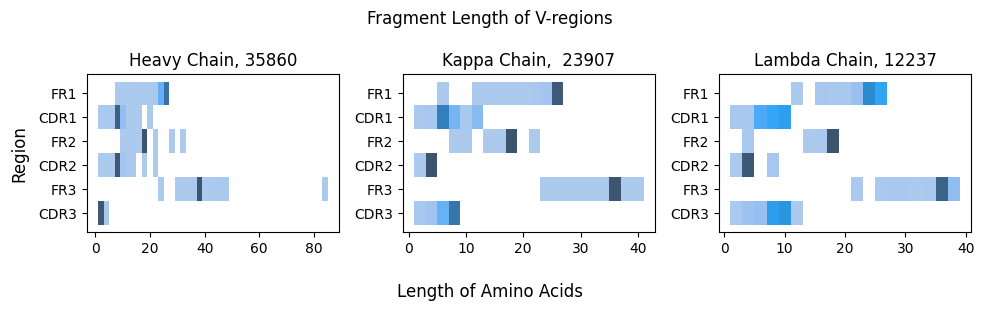

In [133]:
specie = 'Homo sapiens'
PlotRegion.hist_region_len(df, specie)

In [171]:
sdf = df[(df['specie']==specie) & (df['region_name'].str.contains('IMGT'))]
cols = ['chain_type', 'region_name', 'avg_bfactor', 'region_avg_bfactor']
sdf = sdf[cols]
sdf['region_name'] = sdf['region_name'].map(lambda x: x.replace('-IMGT', ''))
sdf

,chain_type,region_name,avg_bfactor,region_avg_bfactor
38,H,FR1,82.9404,94.536800
39,H,CDR1,82.9404,74.080000
40,H,FR2,82.9404,75.563529
41,H,CDR2,82.9404,82.517500
42,H,FR3,82.9404,85.366842
...,...,...,...,...
208238,K,CDR1,0.0000,0.000000
208239,K,FR2,0.0000,0.000000
208240,K,CDR2,0.0000,0.000000
208241,K,FR3,0.0000,0.000000


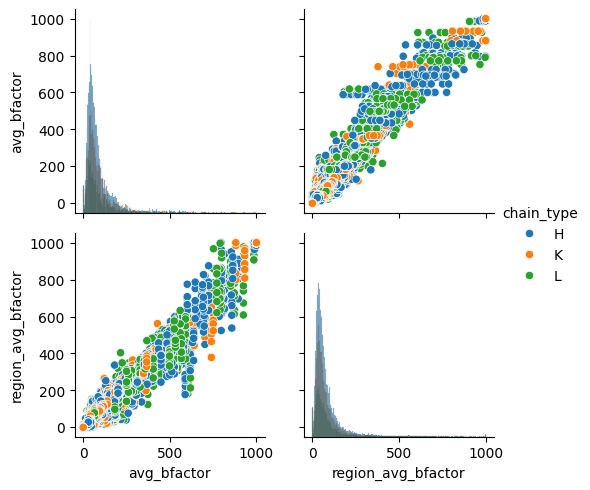

In [175]:
g = sns.PairGrid(sdf, hue='chain_type')
g.map_diag(sns.histplot)
g.map_offdiag(sns.scatterplot)
g.add_legend()

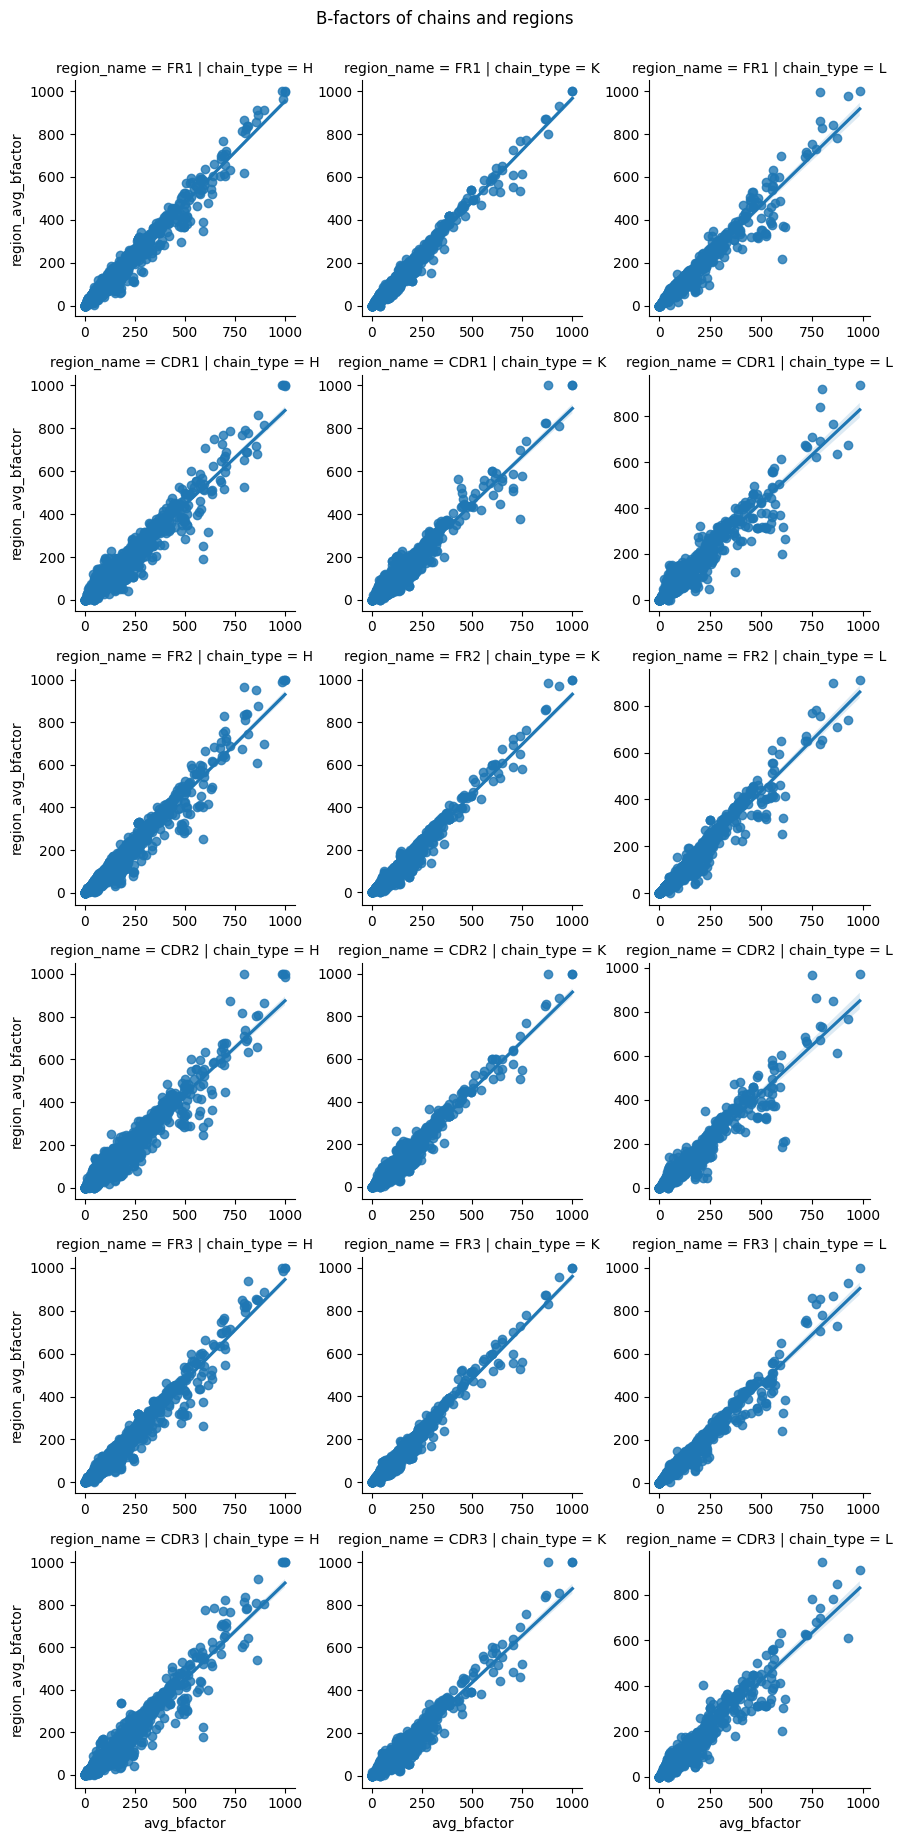

In [214]:
# Create the regression plots with facets
g = sns.lmplot(data=sdf, x="avg_bfactor", y="region_avg_bfactor",
    col="chain_type", row="region_name",
    height=3, facet_kws=dict(sharex=False, sharey=False),
)
g.fig.suptitle("B-factors of chains and regions", y=1.02)

plt.show()

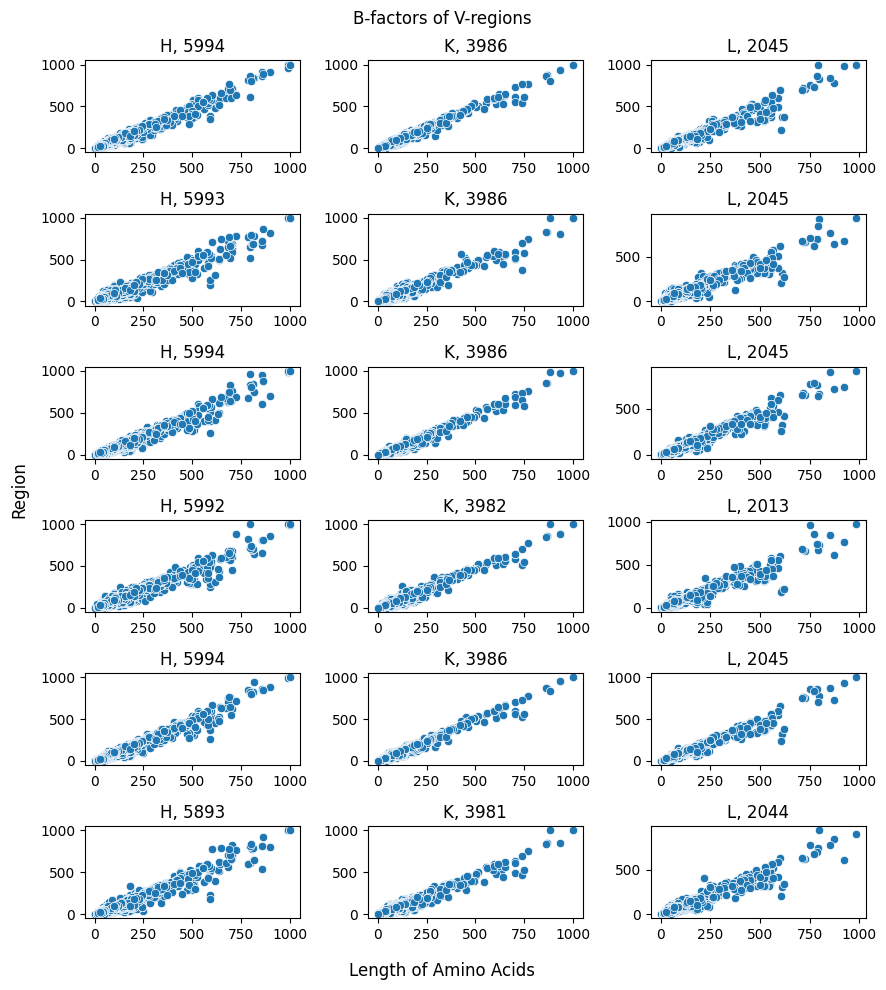

In [177]:
fig, ax = plt.subplots(6,3, figsize=(9,10), layout='tight')
fig.suptitle("B-factors of V-regions")
fig.supxlabel('Length of Amino Acids')
fig.supylabel('Region')

region_names = sdf['region_name'].unique()
chain_types = sdf['chain_type'].unique()
for i, region_name in enumerate(region_names):
    for j, chain_type in enumerate(chain_types):
        sub = sdf[(sdf['region_name']==region_name)&(sdf['chain_type']==chain_type)]
        sns.scatterplot(sub, x='avg_bfactor', y='region_avg_bfactor', ax=ax[i][j])
        ax[i][j].set_title(f"{chain_type}, {len(sub)}")
        ax[i][j].set_xlabel(None)
        ax[i][j].set_ylabel(None)
plt.show()

## secondary structure

In [236]:
chain_types = {'H':'Heavy', 'K':'Kappa', 'L':'Lambda',}
DSSP_CODES ={
    'H': 'alpha helix',
    'B': 'isolated beta bridge',
    'E': 'beta sheet',
    'S': 'bend',  #local, sharp turn 
    'G': '310 helix',
    'I': 'Pi helix',
    'T': 'hydrogen-bonded turn',
    'C': 'coil or unstructured region',
    '-': 'loop',
} 

In [244]:
pool = []
for i, row in df.iterrows():
    try:
        basic = {
            'region_name': row['region_name'].replace('-IMGT', ''),
            'specie': row['specie'],
            'chain_type': chain_types.get(row['chain_type']),
        }
        if 'IMGT' in row['region_name']:
            region_bfactor = row['region_bfactor'].split(',')
            region_dssp = list(row['region_dssp'])
            for b, d in zip(region_bfactor, region_dssp):
                rec = {
                    'bfactor': float(b),
                    'dssp': DSSP_CODES.get(d, 'loop'),
                }
                rec.update(basic)
                pool.append(rec)
    except Exception as e:
        pass
ddf = pd.DataFrame(pool)

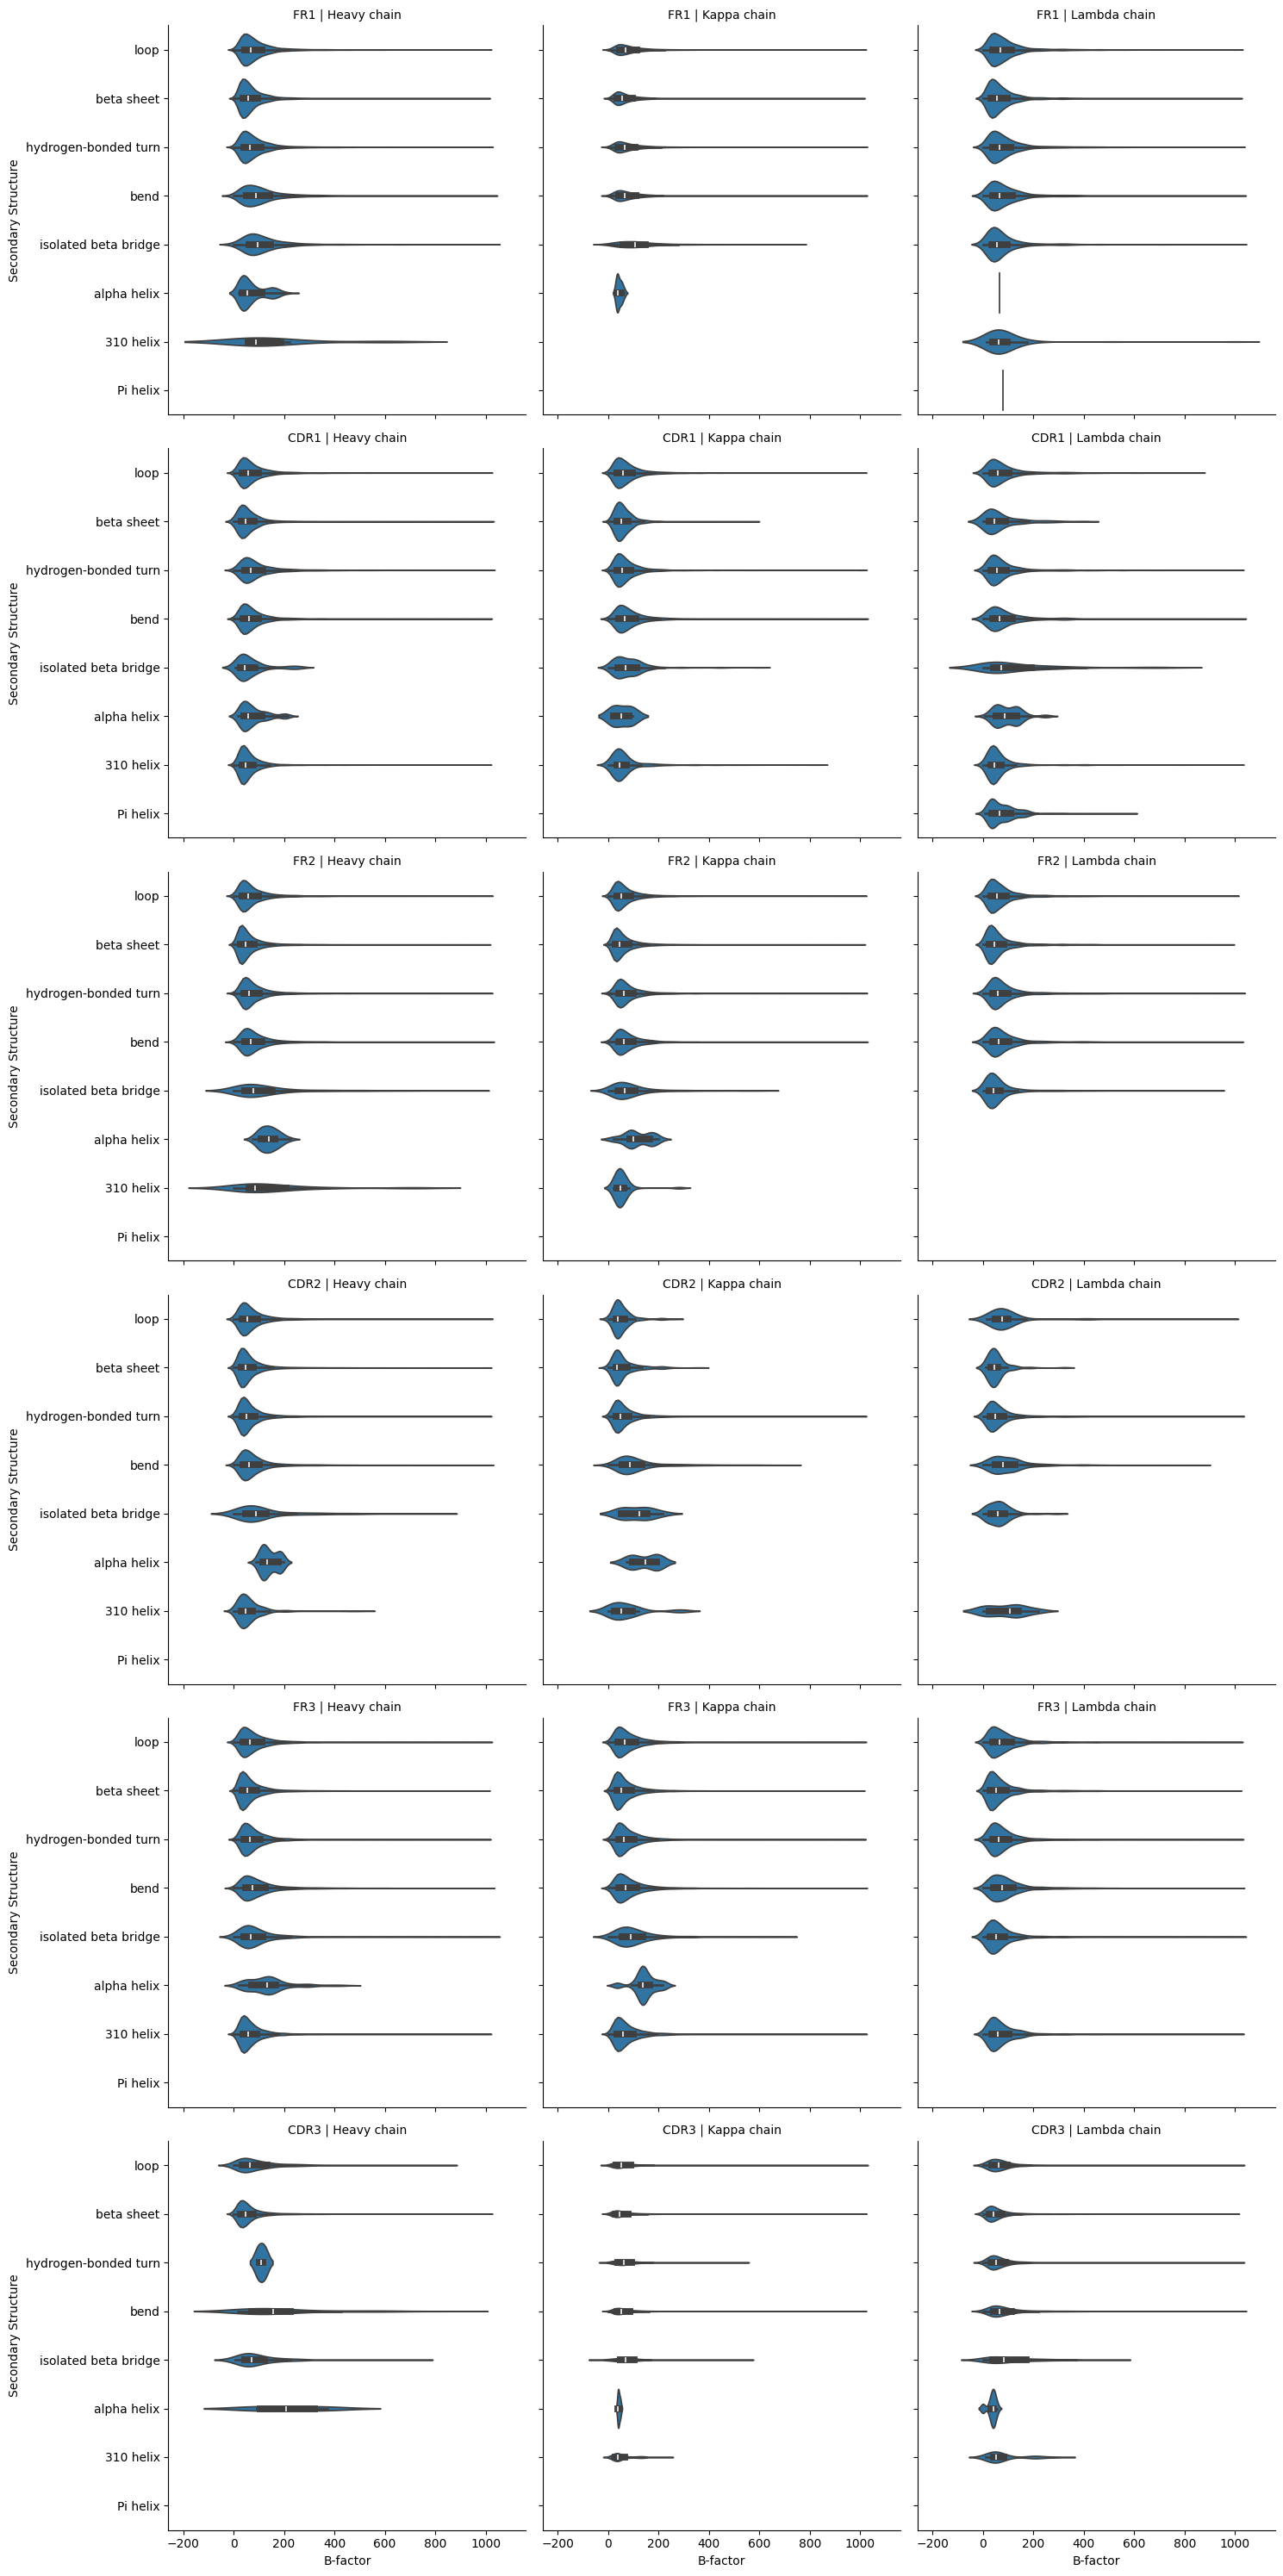

In [246]:
# B-factor distribution
specie = "Homo sapiens"
sddf = ddf[ddf['specie']==specie]
sddf.head()

g = sns.FacetGrid(sddf, row='region_name', col='chain_type', height=5)
g.map_dataframe(sns.violinplot, y='dssp', x='bfactor')
g.set_axis_labels("B-factor", "Secondary Structure")
g.set_titles(col_template="{col_name} chain", row_template="{row_name}")
g.tight_layout()

### percentage of DSSP in fragements of v-region

In [334]:
dssp_pool = {}
len_pool = {}
for i, row in df.iterrows():
    try:
        if 'IMGT' in row['region_name']:
            region_name = row['region_name'].replace('-IMGT', '')
            specie = row['specie']
            chain_type = chain_types.get(row['chain_type'])
            seq_len = len(row['seq'])
            key = (specie, chain_type, region_name)
            if key not in len_pool:
                len_pool[key] = {}
            if 'total_len' not in len_pool[key]:
                len_pool[key]['total_len'] = 0
            if 'num_chain' not in len_pool[key]:
                len_pool[key]['num_chain'] = 0
            len_pool[key]['total_len'] += seq_len
            len_pool[key]['num_chain'] += 1
            if 'IMGT' in row['region_name']:
                region_dssp = list(row['region_dssp'])
                for d in region_dssp:
                    d = DSSP_CODES.get(d, 'loop')
                    if key not in dssp_pool:
                        dssp_pool[key]= {}
                    if d not in dssp_pool[key]:
                        dssp_pool[key][d] = 0
                    dssp_pool[key][d] +=1
    except Exception as e:
        # print(e)
        pass

In [364]:

gdf1 = pd.DataFrame.from_dict(dssp_pool, orient='index')
gdf2 = pd.DataFrame.from_dict(len_pool, orient='index')
gdf2 = gdf2.loc[gdf1.index]
gdf = gdf1.div(gdf2['total_len'], axis=0)*100
gdf = gdf.fillna(0)
gdf = gdf.stack().reset_index()
gdf.columns = ['specie','chain_type','region_name', 'structure', 'percent']
gdf = gdf.sort_values(['specie','chain_type',])
gdf.head()

,specie,chain_type,region_name,structure,percent
320,Bos taurus,Heavy,FR1,loop,24.849398
321,Bos taurus,Heavy,FR1,beta sheet,54.894578
322,Bos taurus,Heavy,FR1,bend,12.801205
323,Bos taurus,Heavy,FR1,hydrogen-bonded turn,6.927711
324,Bos taurus,Heavy,FR1,isolated beta bridge,0.527108


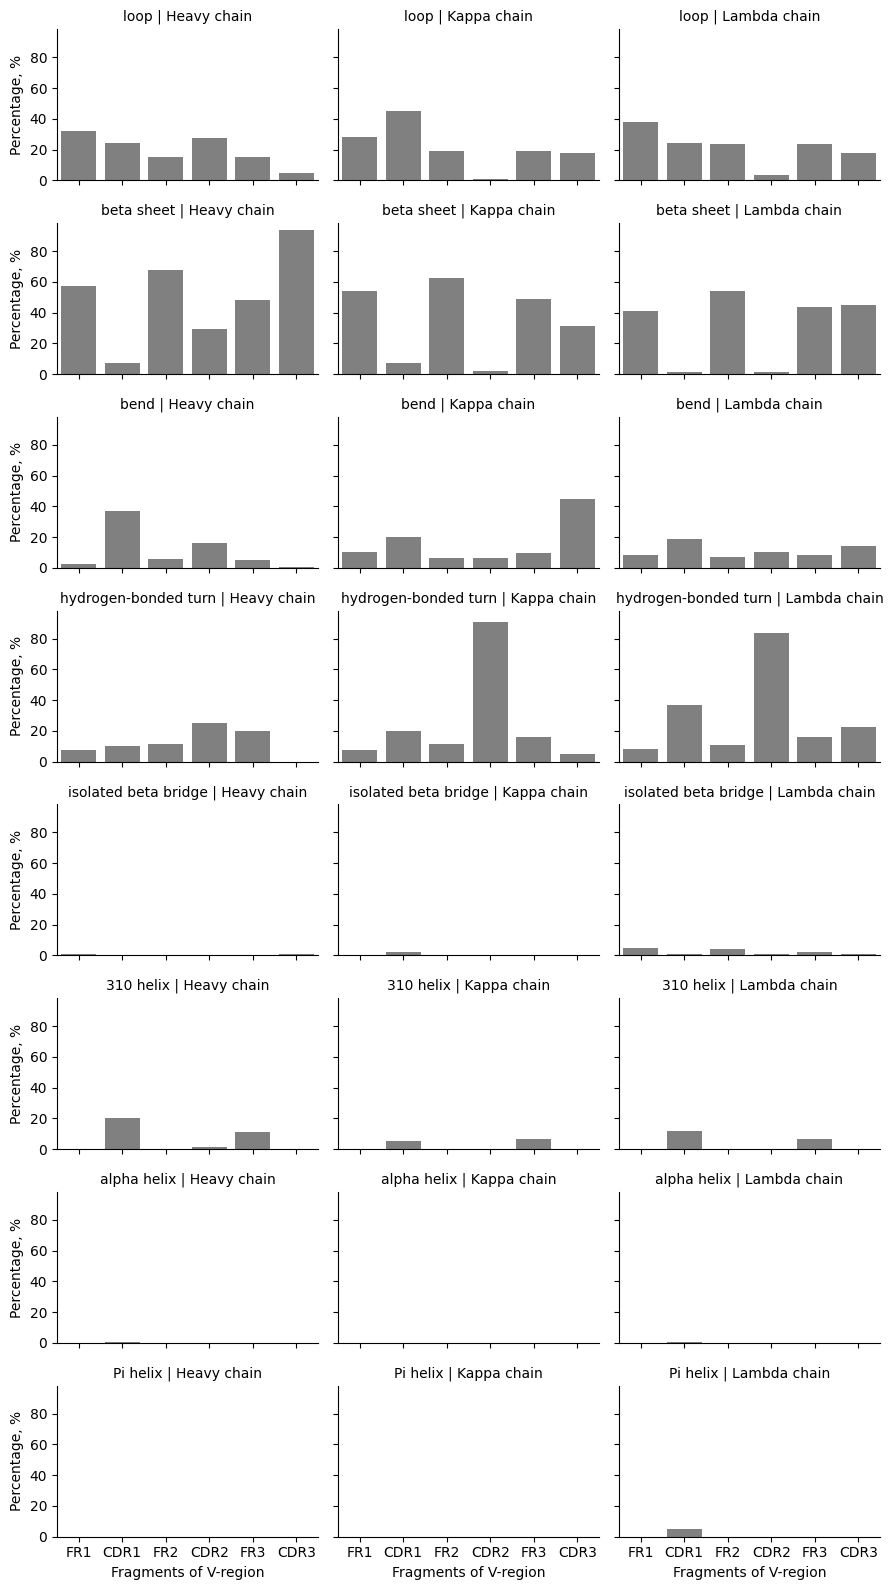

In [365]:
specie = 'Homo sapiens'
sgdf = gdf[gdf['specie']==specie]
g = sns.FacetGrid(sgdf, col='chain_type', row='structure', height=2, aspect=1.5)
g.map(sns.barplot, 'region_name', 'percent', order=['FR1', 'CDR1','FR2', 'CDR2','FR3', 'CDR3'], color='grey')

g.set_titles(col_template="{col_name} chain", row_template="{row_name}")
g.set_axis_labels('Fragments of V-region', 'Percentage, %')
g.tight_layout()

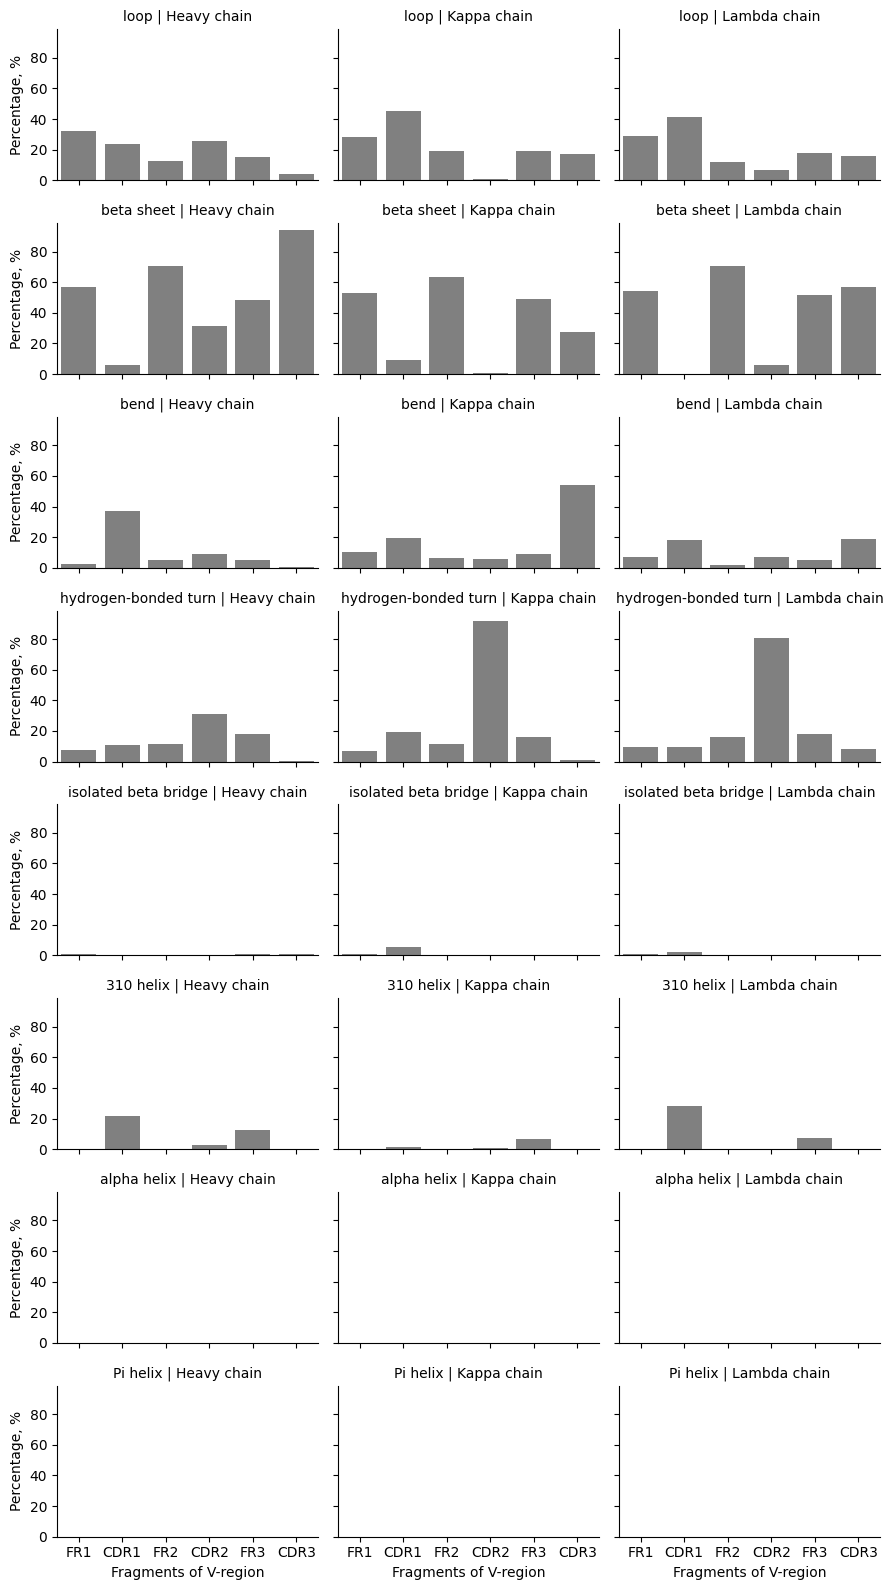

In [366]:
specie = 'Mus musculus'
sgdf = gdf[gdf['specie']==specie]
g = sns.FacetGrid(sgdf, col='chain_type', row='structure', height=2, aspect=1.5)
g.map(sns.barplot, 'region_name', 'percent', order=['FR1', 'CDR1','FR2', 'CDR2','FR3', 'CDR3'], color='grey')

g.set_titles(col_template="{col_name} chain", row_template="{row_name}")
g.set_axis_labels('Fragments of V-region', 'Percentage, %')
g.tight_layout()